# Bayesian mixture models

[Mixture models](mixture_models.ipynb) introduced how we can infer the parameters of a mixture model using the EM algorithm. Here we will treat the parameters as random variables and place prior distributions over them. We will infer those parameters, i.e. the latent class assignments, and model parameters, using *Gibbs sampling*. We'll validate our implementation using `Stan`. We will also make fairly simple examples, i.e. normally distributed components with sufficiently large mean differences, to avoid staticial deficiencies. For a better treatment of the topic see Michael Betancourt's [case study](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html) and Sylvia Frühwirth-Schnatter's [book](https://www.springer.com/de/book/9780387329093)  (and/or my own [summary](https://dirmeier.github.io/on-everything/on_mixtures.html)).

**As usual I do not take warranty for the correctness or completeness of this document.**

A Bayesian mixture model with latent class assignments has the following hierarchical form:

\begin{align*}
\boldsymbol \theta_k & \sim \mathcal{G}_0\\
\boldsymbol \pi &  \sim \text{Dirichlet}(\boldsymbol \alpha_0)\\
z_i &  \sim \text{Discrete}(\boldsymbol \pi)\\
\mathbf{x}_i \mid z_n = k &  \sim {P}(\boldsymbol \theta_k)
\end{align*}

where $\mathcal{G}_0$ is some base distribution for the model parameters. For the variables of interest, $\boldsymbol  \theta_k$ and $\boldsymbol z$ the posterior is:

\begin{align*}
P(\boldsymbol \theta, \boldsymbol z, \boldsymbol \pi \mid \mathbf{X}) \propto P(\mathbf{X} \mid \boldsymbol \theta, \boldsymbol z, \boldsymbol \pi ) P(\boldsymbol \theta) P ( \boldsymbol z \mid \boldsymbol \pi  ) P( \boldsymbol \pi )
\end{align*}

In the Gaussian case, using conjugate priors for means and covariances (Normal-Inverse-Wishart), could result in the following hierarchical structure (where other hyperparameters are of course equally fine):

\begin{align*}
\boldsymbol  \Sigma_k & \sim \mathcal{IW}\\
\boldsymbol  \mu_k  & \sim \mathcal{N}(\boldsymbol \mu_0, \sigma^2_0 \mathbf{I})\\
\boldsymbol \pi &  \sim \text{Dirichlet}(1.0,\dots, 1.0)\\
z_i &  \sim \text{Discrete}(\boldsymbol \pi)\\
\mathbf{x}_i \mid z_n = k &  \sim \mathcal{N}(\boldsymbol \mu_k, \boldsymbol \Sigma_k).\end{align*}

So we use the same hyperparameters for the priors of the means which could result in degeneracies but is unproblematic here (see Michael Betancourt's [case study](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html)). Generally we should use non-exchangable priors with different means to break this degeneracy.

Inference in the Gaussian case whe using conjugate priors is particularly easy, since we only need to iterate three steps for each Gibbs iteration:

1) sample $z_i \sim P(z_i \mid \mathbf{z}_{-i}, \mathbf{X}, \boldsymbol \pi, \boldsymbol \theta) \propto P(z_i \mid \boldsymbol \pi) P(\mathbf{x}_i \mid \boldsymbol \theta_{z_i})$

2) sample $\boldsymbol \theta_k \sim P(\boldsymbol \theta_k \mid \mathbf{z}, \mathbf{X}, \boldsymbol \pi)$

3) sample $\boldsymbol \pi \sim  P(\boldsymbol \pi \mid \mathbf{z}, \mathbf{X}, \boldsymbol \theta)$

where I used the same notation as above for the parameters. For brevity, we will set $\boldsymbol \Sigma_k$ fixed for all $k$ for our Gibbs sampler. This doesn't change much but we don't need to do some linalg. We'll later add it when we infer the posteriors using Stan.

In [1]:
options(repr.fig.width=4, repr.plot.height=3)

In [2]:
suppressMessages(library("e1071"))
suppressMessages(library("mvtnorm"))
suppressMessages(library("dplyr"))
suppressMessages(library("ggplot2"))
suppressMessages(library("MCMCpack"))
set.seed(23)

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

First we set the data and some constants. We create a very simple data set to avoid problems with identifiability and label switching. For a treatment of the topic see Michael Betancourt's [case study](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html).

In [3]:
n <- 100
p <- 2
K <- 3
sigma <- .5 * diag(p)
mus <- matrix(c(0, 5, 10, 0, 5, 10), ncol = 2)

In [4]:
# latent class assignments
Z <- sample(1:K, 100, TRUE)
# mixture
X <- matrix(0, n, 2)
for (i in seq(3)) {
    X[Z == i, ] <- mvtnorm::rmvnorm(sum(Z == i), mus[i,], sigma)   
}

Let's plot our data and color the clusters.

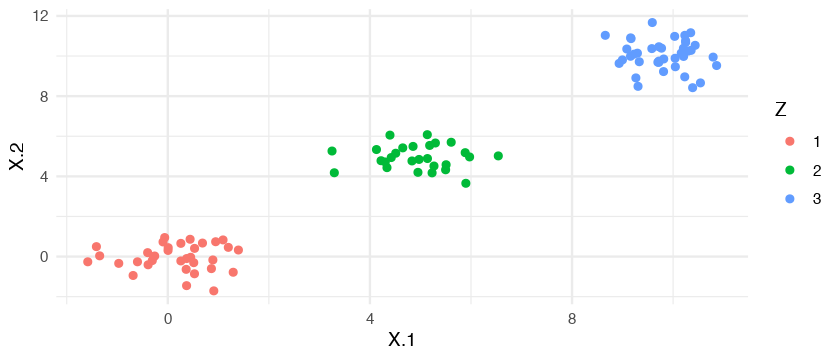

In [5]:
data.frame(X=X, Z=as.factor(Z)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Define the priors of the model. As noted above, normal priors for the means and a Dirichlet for the mixing weights. We set the covariances to be fixed.

In [6]:
mu.prior <- matrix(c(0, 5, 10, 0, 5, 10), ncol = 2)
sigma.prior <- diag(p)
q.prior <- solve(sigma.prior)

alpha.hyper <- c(1, 1, 1)
pi.prior <- rdirichlet(1, alpha.hyper)

We start with a random assignment of data points to clusters.

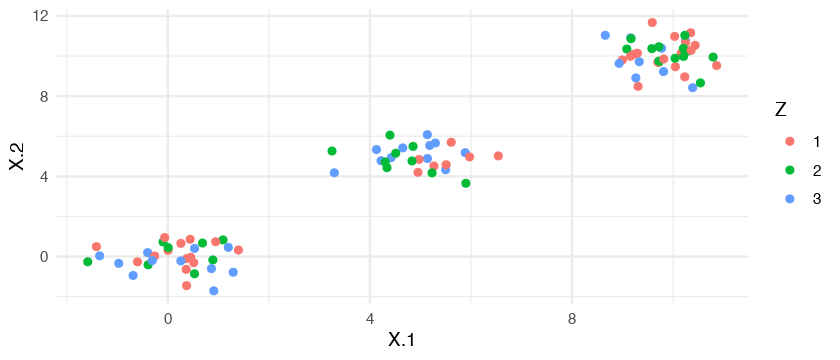

In [7]:
# initialization of the cluster assignments
zs <- sample(1:3, n, replace = TRUE)
data.frame(X=X, Z=as.factor(zs)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

To infer the posterior we use the Gibbs sampler described above.

In [8]:
for (iter in seq(100))
{
    # compute conditional posterior P(Z \mid ...)
    probs <- sapply(1:3, 
                    function(k) pi.prior[k] * dmvnorm(X, mu.prior[k, ], sigma.prior))
    probs <- sweep(probs, 1, rowSums(probs), "/")
    zs <- sapply(seq(n), function(i) rdiscrete(1, probs=probs[i, ]))

    # compute conditional posterior P(mu \mid ...)
    tables <- c(0, 0, 0)
    for(k in seq(K)) {
      Xk <- X[zs == k, ]
      tables[k] <- nrow(Xk)
      
      denom <- solve(q.prior + tables[k] * q.prior)
      nominator <- tables[k] * q.prior %*% apply(Xk, 2, mean)
      mu.prior[k, ] <- mvtnorm::rmvnorm(1, denom %*% nominator, denom)
    }
                 
    # compute conditional posterior P(pi \mid ...)
    pis <- rdirichlet(1, alpha = alpha.hyper + tables)
}

I only save the last sample of the class assignments, since we only want to plot if we inferred everything correctly.
After the Gibbs iterations, we plot the last sample of the class assignments.

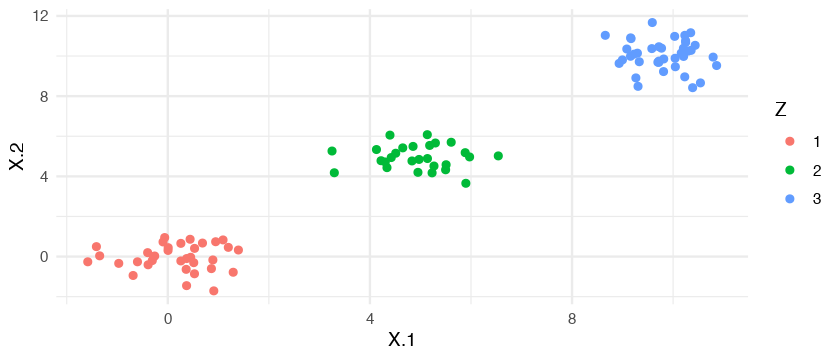

In [9]:
# initialization of the cluster assignments
data.frame(X=X, Z=as.factor(zs)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Nice that worked just great.

## Inference using STAN

Except as a nice intellectual exercise it doesn't make a lot of sense to implement the sampler ourselves. With Stan fitting a mixture boils down to defining the model as `stan`-file. Since we cannot use the hierarchical model from above in Stan, i.e. with the latent variables $Z$, we first marginalize them out. The model is then:

\begin{align*}
\boldsymbol  \Sigma_k & \sim \mathcal{IW}\\
\boldsymbol  \mu_k  & \sim \mathcal{N}(\boldsymbol \mu_0, \sigma^2_0 \mathbf{I})\\
\boldsymbol \pi &  \sim \text{Dirichlet}(1.0,\dots, 1.0)\\
\mathbf{x}_i &  \sim \sum_i^k  \pi_i\mathcal{N}(\boldsymbol \mu_k, \boldsymbol \Sigma_k).
\end{align*}

We use prior means with variance $\sigma_0^2 = 5$ and, since Stan offers it, an $LKJ$ prior for the covariance matrix (shared among all components).

In [10]:
library(rstan)
rstan_options(auto_write = TRUE)

Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:coda’:

    traceplot



The code block is fairly short. Note that we use a `lkj_corr` prior alone, so we implictely use prior scales of $1$. Additionally we set an order to the means to break labeling degeneracy.

In [11]:
stan.file <- "_models/bayesian_gmm.stan"
cat(readLines(stan.file), sep = "\n")

data {
	int<lower=0> n;
	int<lower=1> p;
	row_vector[p] x[n];
	vector<lower=0>[3] alpha;
}

parameters {
	ordered[p] mu[3];
	simplex[3] theta;
	cholesky_factor_corr[p] L;
}

model {	
	real mix[3];
	L ~ lkj_corr_cholesky(5);
	

	theta ~ dirichlet(alpha);
	for (i in 1:3) 
	{
		mu[i] ~ normal(0, 5);
	}

 	for (i in 1:n) 
 	{
 		for (k in 1:3) 
 		{
 			mix[k] = log(theta[k]) + multi_normal_cholesky_lpdf(x[i] | mu[k], L);
 		}
 		target += log_sum_exp(mix);
 	}
}


In [17]:
fit <- stan(file=stan.file, data=list(n=n, p=p, x=X, alpha=c(1, 1, 1)), iter=10000, warmup=1000, chains=2)


SAMPLING FOR MODEL 'bayesian_gmm' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000692 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 6.92 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 1001 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 13.9288 seconds (Warm-up)
Chain 1:                134.098 seconds (Sampling)


Looking at the posterior quantiles shows that we nicely inferred the original parameters

In [18]:
fit

Inference for Stan model: bayesian_gmm.
2 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=18000.

            mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
mu[1,1]     9.77    0.00 0.14    9.47    9.67    9.77    9.87   10.04 11243
mu[1,2]    10.08    0.00 0.14    9.80    9.98   10.07   10.17   10.37 15211
mu[2,1]    -0.02    0.00 0.13   -0.28   -0.11   -0.02    0.07    0.23 13743
mu[2,2]     0.13    0.00 0.13   -0.11    0.05    0.13    0.22    0.40 19139
mu[3,1]     4.82    0.00 0.15    4.50    4.72    4.83    4.93    5.11 12449
mu[3,2]     5.06    0.00 0.15    4.77    4.96    5.06    5.16    5.38 19934
theta[1]    0.39    0.00 0.05    0.30    0.36    0.39    0.42    0.48 17345
theta[2]    0.34    0.00 0.05    0.25    0.31    0.34    0.37    0.43 16200
theta[3]    0.27    0.00 0.04    0.19    0.24    0.27    0.30    0.36 17129
L[1,1]      1.00     NaN 0.00    1.00    1.00    1.00    1.00    1.00   NaN
L[1,

Looks good! Let's extract the means of the posterior means and assign each data point to a cluster.

In [19]:
posterior <- extract(fit)
post.mus <- do.call(
    "rbind", 
    lapply(
        1:3, function(i) apply(posterior$mu[,i,], 2, mean))
)

Compute most likely assignments. Note that we should probably average over the entire posterior, but given the thin posterior quantiles and the fact that our data are well separated, it's not necessary here and only leads to longer computations.

In [20]:
probs <- data.frame(
    Z1 = mvtnorm::dmvnorm(X, post.mus[1,], diag(2)),
    Z2 = mvtnorm::dmvnorm(X, post.mus[2,], diag(2)),
    Z3 = mvtnorm::dmvnorm(X, post.mus[3,], diag(2)))
zs.stan <- apply(probs, 1, which.max)

And plot everything again.

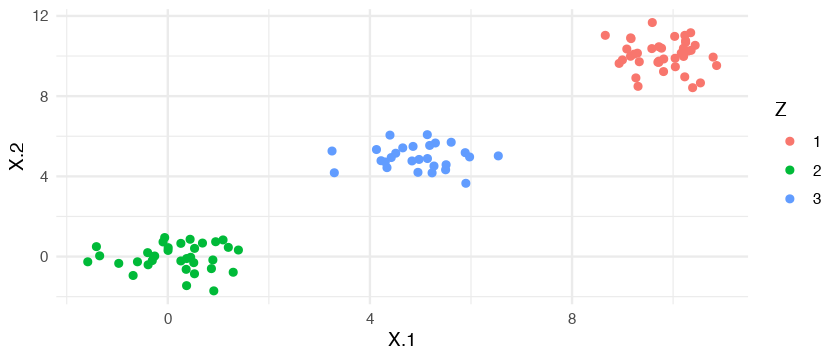

In [21]:
# initialization of the cluster assignments
data.frame(X=X, Z=as.factor(zs.stan)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Worked the same as before.